**Test Environment Notebook**
------

In [1]:
### Tool imports
import joblib as jbl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### sklearn tool imports
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

### sklearn model imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

### Local imports
import utils.data_handling_lib as dhl
import utils.graphics_lib as gl

from utils.data_handling_lib import RANDOM_STATE

Create raw test dataset

In [2]:
dataset_file_path = "datasets/winequality-combined.csv"
test_raw_data = dhl.load_data(dataset_file_path)

In [4]:
#sil_scores_100 = ctl.give_silhouette_scores(train, range_upper=100)
#jbl.dump(sil_scores_100, "exports/misc/sil_scores_100.txt")

sil_scores_100 = jbl.load("exports/misc/sil_scores_100.txt")

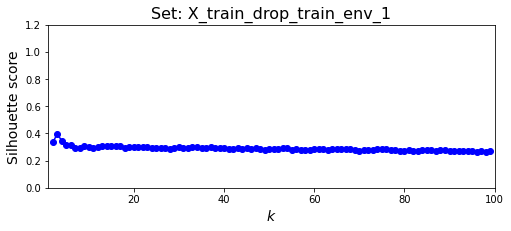

In [5]:
gl.plot_silhouette_scores(sil_scores_100, var_name="X_train_drop_train_env_1")

Test for large numbers of clusters, performance stagnates as k increases.

In [6]:
#sil_scores_15 = ctl.get_silhouette_scores(train, range_upper=15)
#jbl.dump(sil_scores_15, "exports/misc/sil_scores_15.txt")

sil_scores_15 = jbl.load("exports/misc/sil_scores_15.txt")

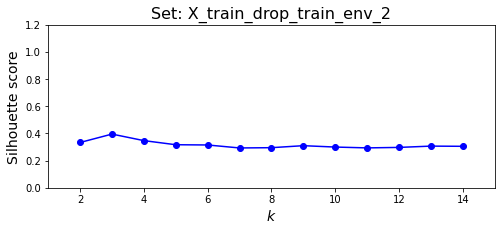

In [7]:
gl.plot_silhouette_scores(sil_scores_15, var_name="X_train_drop_train_env_2")

This drop set also performs relatively poorly.

**Testing SVR and RandomForestRegressor with Highest-Performing Clustered Drop Sets**

The first example will use a set of variables tagged "df2" for "drop_features_2", and will be compared to a model fit to the original training set.
A more condensed version will be created with "df3".

Import data into a new frame to copy from

In [8]:
test_raw_data2 = dhl.load_data()
X_train_raw, y_train, X_test_raw, y_test = dhl.strat_split_dataset(X=test_raw_data2, label_id="quality")

drop_features_n lists copied from explore environment

In [9]:
### Included: free sulphur dioxide, total sulfur dioxide, pH, sulphates, alcohol
included_features_2 = ["free sulfur dioxide", "total sulfur dioxide", "pH", "sulphates", "alcohol"]
drop_features_2 = ["fixed acidity", "volatile acidity", "density", "residual sugar", "chlorides", "citric acid", "color"]
X_train_drop2, X_test_drop2 = X_train_raw.drop(drop_features_2, axis=1), X_test_raw.drop(drop_features_2, axis=1)

### Included: Volatile acidity, alcohol, density
included_features_3 = ["volatile acidity", "alcohol", "density"]
# Overaggressive and will likely overfit, but interesting to see.
drop_features_3 = ["fixed acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","pH","sulphates","color"]
X_train_drop3, X_test_drop3 = X_train_raw.drop(drop_features_3, axis=1), X_test_raw.drop(drop_features_3, axis=1)

Create and fit KMeans object, and append clustering results to original dataframe

In [10]:
kmeans_df2 = KMeans(
    n_clusters=2,
    n_init=10,
    max_iter=300,
    random_state=RANDOM_STATE
)

# Fit to the training data
kmeans_df2.fit(X_train_drop2)

new_X_train_df2 = X_train_raw.drop(included_features_2, axis=1)
new_X_test_df2 = X_test_raw.drop(included_features_2, axis=1)

# Generate out clusters
train_cluster_df2 = kmeans_df2.predict(X_train_drop2)
test_cluster_df2 = kmeans_df2.predict(X_test_drop2)

In [11]:
# Add the target and predicted clusters to our training DataFrame
new_X_train_df2.insert(7, 'cluster', train_cluster_df2) 
new_X_test_df2.insert(7, 'cluster', test_cluster_df2)

Create df2 and original model objects

In [12]:
svr_df2 = SVR(kernel="rbf")
rf_reg_df2 = RandomForestRegressor(n_estimators=1000, random_state=RANDOM_STATE)
lin_reg_df2 = LinearRegression()

svr_ori = SVR(kernel="rbf")
rf_reg_ori = RandomForestRegressor(n_estimators=1000, random_state=RANDOM_STATE)
lin_reg_ori = LinearRegression()

Fit each model

In [13]:
# SVR
svr_df2.fit(new_X_train_df2, y_train)
svr_ori.fit(X_train_raw, y_train)

SVR()

In [14]:
# Random Forest
rf_reg_df2.fit(new_X_train_df2, y_train)
rf_reg_ori.fit(X_train_raw, y_train)

RandomForestRegressor(n_estimators=1000, random_state=17)

In [15]:
# Linear Regression
lin_reg_df2.fit(new_X_train_df2, y_train)
lin_reg_ori.fit(X_train_raw, y_train)

LinearRegression()

Scores

In [16]:
df2_models = [svr_df2, rf_reg_df2, lin_reg_df2]
ori_models = [svr_ori, rf_reg_ori, lin_reg_ori]

def print_scores(models, X, y):
    for model in models:
        print(f"{model.__getattribute__}: {model.score(X=X, y=y)}")

In [17]:
print_scores(df2_models, new_X_test_df2, y_test)
print_scores(ori_models, X_test_raw, y_test)

<method-wrapper '__getattribute__' of SVR object at 0x00000211EBD1F430>: 0.10401714740243884
<method-wrapper '__getattribute__' of RandomForestRegressor object at 0x00000211EBD1F190>: 0.45924614225856286
<method-wrapper '__getattribute__' of LinearRegression object at 0x00000211AD455D30>: 0.2267074903013867
<method-wrapper '__getattribute__' of SVR object at 0x00000211EBD319A0>: 0.15755139312705313
<method-wrapper '__getattribute__' of RandomForestRegressor object at 0x00000211EBD31910>: 0.5233800271378029
<method-wrapper '__getattribute__' of LinearRegression object at 0x00000211AD26AF40>: 0.2815441120683513


The scores appear to show that the RandomForestRegressor has the best performance, although it performs slightly worse with KMeans clustering.

Testing RandomForestRegressor with df3

In [18]:
kmeans_df3 = KMeans(
    n_clusters=2,
    n_init=10,
    max_iter=300,
    random_state=RANDOM_STATE
)

# Fit to the training data
kmeans_df3.fit(X_train_drop3)

new_X_train_df3 = X_train_raw.drop(included_features_3, axis=1)
new_X_test_df3 = X_test_raw.drop(included_features_3, axis=1)

# Generate out clusters
train_cluster_df3 = kmeans_df3.predict(X_train_drop3)
test_cluster_df3 = kmeans_df3.predict(X_test_drop3)

# Add the target and predicted clusters to our training DataFrame
new_X_train_df3.insert(7,'cluster', train_cluster_df3) 
new_X_test_df3.insert(7, "cluster", test_cluster_df3)

rf_reg_df3 = RandomForestRegressor(n_estimators=1000, random_state=RANDOM_STATE)

rf_reg_df3.fit(new_X_train_df3, y_train)
rfr_df3_score = rf_reg_df3.score(new_X_test_df3, y_test)

rfr_ori_score = rf_reg_ori.score(X_test_raw, y_test)

print(f"KMeans clustered regressor score: \n {rfr_df3_score}",
      f"\n\nOriginal regressor score: \n {rfr_ori_score}")

KMeans clustered regressor score: 
 0.47549295714843365 

Original regressor score: 
 0.5233800271378029


This selection of variables leads to marginally better performance